In [0]:
import numpy as np
import math
import torch
import torchvision
import torchvision.transforms as transforms

In [196]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  car


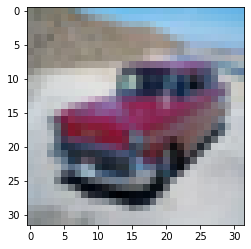

In [197]:
#https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#Let us show some of the training images, for fun.
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

In [276]:
#getting the x(2d matrix of 50000*3072, input images), and y(1*3072, output label);
tmpTrain = trainloader.dataset.data # shape of 50000*32*32*3 need to transform to 50000*3072
x,y1,y2,y3 = tmpTrain.shape
trainX = np.zeros([x, y1*y2*y3])
tmpTrainY = trainloader.dataset.targets
trainY = np.zeros([len(tmpTrainY), len(classes)])
for i in range(len(tmpTrainY)):
  trainY[i][tmpTrainY[i]] = 1
tmpTest = testloader.dataset.data # shape of 10000*32*32*3 need to transform to 10000*3072
xx, y4, y5, y6 = tmpTest.shape
testY = testloader.dataset.targets
testX = np.zeros([xx, y4*y5*y6])
for i in range(x):
  trainX[i] = tmpTrain[i].flatten()

trainX = trainX / np.linalg.norm(trainX) 
for j in range(xx):
  testX[j] = tmpTest[j].flatten()

testX = testX / np.linalg.norm(testX)

print("the shape of matrix trainX" + str(trainX.shape))
print("the size of trainY " + str(trainY.shape))
print("the shape of matrix testX" + str(testX.shape))
print("the size of testY " + str(len(testY)))
print(trainX[15])




the shape of matrix trainX(50000, 3072)
the size of trainY (50000, 10)
the shape of matrix testX(10000, 3072)
the size of testY 10000
[5.90271027e-05 9.91655325e-05 1.36352607e-04 ... 9.56239063e-05
 1.09200140e-04 1.19234747e-04]


In [0]:
#activation functions

def relu(x):
  N, D = x.shape
  ans = np.zeros([N,D])
  for i in range(N):
    for j in range(D):
      if x[i][j] > 0:
        ans[i][j] = x[i][j]
      else:
        ans[i][j] = 0
  return ans

def sigmoid(x):
  N, D = x.shape
  ans = np.zeros([N,D])
  for i in range(N):
    for j in range(D):
      try:
        ans[i][j] = 1/(1+math.exp(-x[i][j]))
      except OverflowError:
        if(x[i][j])>0:
          ans[i][j] = 1
        else:
          ans[i][j] = 0
  return ans


In [0]:
#define weights for different layers, put them in a list called Ws, each weight has a shape of size(l-1)*size(l)
layerNumber = [1024,100] #number of hidden layers and number of nodes in each layer
AV = sigmoid #activation function that we use 
Ws = []
N,D = trainX.shape
start = D
N,DD =trainY.shape
end = layerNumber[0]
w = np.random.randn(start, end)*.01
for i in range(start):
  for j in range(end):
    w[i][j] = 0
Ws.append(w)
for i in range(len(layerNumber)):
  start = layerNumber[i]
  if i+1 == len(layerNumber):
    end = DD
  else:
    end = layerNumber[i+1]
  w = np.random.randn(start, end)*.01
  Ws.append(w)

In [0]:
Zs = [] #hidden layers

def getYhead(X):
  Y = []
  N,D = X.shape
  Zs.clear()
  for layer in layerNumber:
    Zs.append(np.zeros([N,layer]))
  Yhead = np.zeros([N, len(classes)])
  tmp = X
  for i in range(len(Ws)-1):
    NN,DD = tmp.shape
    tmp = AV(np.dot(tmp, Ws[i])) #Doing activation function for the Zs in layer
    Zs[i] = tmp
  Y = sigmoid(np.dot(tmp, Ws[len(Ws)-1])) #Doing sigmoid for final layer since it is binary classification
  return Y



In [0]:
#Cost of one training result
def cost(Y1, Y2):
  total = 0.0
  for i in range(len(Y1)):
    value = (Y1[i]-Y2[i])*(Y1[i]-Y2[i])
    total = total + value
  return total


#Average cost of all training result
def averageCost(Y1, Y2):
  N,D = Y1.shape
  total = 0.0
  for i in range(N):
    total = total + cost(Y1[i],Y2[i])
  return total/N

In [293]:


def gradient(X, Y):
  N,D = X.shape
  Yh = getYhead(X)
  print("Average cost so far " + str(averageCost(Yh, Y)))
  dY = 2*(Yh - Y)
  dZnext =dY
  WsReversed = Ws.copy()
  ZsReversed = Zs.copy()
  WsReversed.reverse() #reverse them since we need to calculate the dw from last layer to the first layer
  ZsReversed.reverse()
  dWs =[]
  w = WsReversed[0]
  z = ZsReversed[0]
  dW = np.dot(z.T, dZnext*Yh*(1-Yh))
  #Probably the problem come from here, I am trying to calculate the dWeight between last hidden layer and final layer
  #now z is the last hidden layer, Yh is the final answer, in the video, derivative of w = al-1*(derivative of sigmoid)*dy
  #al-1 is last hidden layer, Yh*(1-Yh) is the derivative of sigmoid, and dzNext is dy, however if Yh is all zero them dW
  #would be zero and if will keeps like that, and I was like what???
  dZnext = np.dot(dZnext*Yh*(1-Yh), w.T)
  dWs.append(dW)
  for i in range(1, len(WsReversed)):
    w = WsReversed[i]
    zPrevious = ZsReversed[i-1]
    if i >= len(ZsReversed):
      z = X.copy()
    else:
      z = ZsReversed[i]
    Zn, Zd = zPrevious.shape
    dW = np.dot(z.T, dZnext*zPrevious*(1-zPrevious))
    dZnext = np.dot(dZnext*zPrevious*(1-zPrevious), w.T)
    dWs.append(dW)
  dWs.reverse()
  return dWs

def fit(X, Y, lr, eps, bsize):
  N,D = X.shape
  dW = np.inf*np.ones_like(Ws[len(Ws)-1])
  while np.linalg.norm(dW) > eps:
    minibatch = np.random.randint(N, size=(bsize))
    g = gradient(X[minibatch,:], Y[minibatch,:])
    for i in range(len(Ws)):
      Ws[i] = Ws[i]-lr*g[i]
    dW = g[len(Ws)-1]

def getBiggestY(Y): 
  N,D = Y.shape
  result = np.zeros([N])
  for i in range(N):
    biggest = 0
    biggestNum = 0
    for j in range(D):
      if Y[i][j]>biggest:
        biggestNum = j
        biggest = Y[i][j]
      result[i] = j
  return result

def predict(testX, testY):
  print("predicting ...")
  yHead = getYhead(testX)
  yResult = getBiggestY(yHead)
  totalRight = 0.0
  for i in range(len(testY)):
    if(yResult[i] == testY[i]):
      totalRight = totalRight+1
  return totalRight/len(testY)


fit(trainX, trainY, 0.1, 1e-09, 1000)
print(predict(testX, testY))


Average cost so far 1.0
predicting ...
0.1
